In [ ]:
# default_exp vertex_dynamics_models

# Vertex Dynamics Models
> Simulation examples

---

In [ ]:
#hide
from vertex_simulation.primitives import *
from vertex_simulation.simulation import *
import torch, numpy as np, matplotlib.pylab as plt
from mpl_toolkits.mplot3d import axes3d
# after you modify this notebook use "nbdev_build_docs" to build the docs (and readme.md)
# and nbdev_clean_nbs to remove notebook metadata before pushing it
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
device=torch.device('cpu')
if torch.cuda.device_count():
    device=torch.device('cuda:0')
dtype = torch.float32

print(f'Device: {device}\ndtype: {dtype}')

Device: cuda:0
dtype: torch.float32


## Anisotropic contractions

In [ ]:
import networkx as nx

In [ ]:
# let's seed RNG for sanity and reproducibility
np.random.seed(42)

# define cell monolayer
v_x,regions =unit_hexagons(10,10) # unit hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

In [ ]:
cell_graph = Monolayer(vertices=Vertex(v_x.copy().tolist(),dtype=dtype), 
                       edges=torch.tensor(edge_list), 
                       cells=cells)
cell_graph.to_(device)

/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


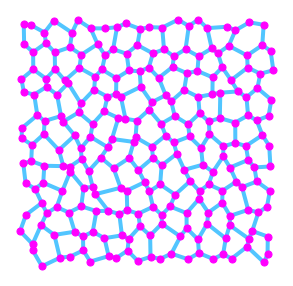

In [ ]:
Gnx,pos=graph2networkx_with_pos(cell_graph)

fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=50,width=4,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')
plt.show()
plt.close()

In [ ]:
# Define energy function
omega_0 = torch.tensor([np.pi/2],dtype=dtype,device=device)
phase = torch.rand((len(edge_list),1)).type(dtype).to(device)
p_keep = 0.5 # fraction to keep active
e_ij_on = (torch.rand((len(edge_list),1))<p_keep).type(dtype).to(device)
omega = torch.randn_like(e_ij_on) + omega_0

def monolayer_energy(monolayer_,Tau):
    Perm = cell_graph.perimeter()
    Area = cell_graph.area()
    Leng = cell_graph.length()
    
    gamma_ij  = e_ij_on*torch.cos(omega*Tau+phase)**2
    gamma_ij_by_lij = Leng*gamma_ij
    Energy_tot = torch.sum(.01*(Perm)**2) + torch.sum((Area-2.3)**2) + torch.sum(gamma_ij_by_lij)
    return Energy_tot, gamma_ij

In [ ]:
# Networkx's edge ordering is different
edge_idx = dict(zip([tuple(e) for e in cell_graph.edges.tolist()],range(cell_graph.edges.shape[0])))
edge_idx_order = [edge_idx[e if e in edge_idx else (e[1],e[0])] for e in Gnx.edges ]
def draw_w_tension(i):
    pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Time : {verts_frames[i]:2.3f}')
    #node_color=range(24), node_size=800, cmap=plt.cm.Blues
    nx.draw(Gnx,pos,node_size=50,width=4,ax=ax,node_color='#FF00FF',
            edge_color=line_tensions[i].numpy().squeeze()[edge_idx_order],edge_cmap=plt.cm.bwr)

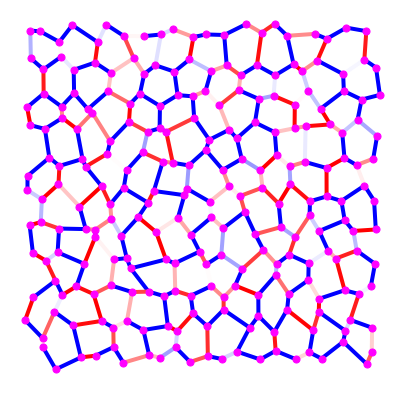

In [ ]:
_,Contractions = monolayer_energy(cell_graph,0)
fig = plt.figure(figsize=[7,7])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=50,width=4,node_color='#FF00FF',
            edge_color=Contractions.cpu().numpy().squeeze()[edge_idx_order],edge_cmap=plt.cm.bwr)

In [ ]:
# Simulation param-s
Dt = 2**-7 # time step size
t = [0]
Energies = []
Forces = []
verts_t =[]
verts_frames=[]
line_tensions=[]
t_total = 2**12

cell_graph.vertices.requires_grad_(True)

Integration (Euler's method):
t=4.000: E=69.21; aver |dx/dt|= 0.43
t=8.000: E=70.62; aver |dx/dt|= 0.49
t=12.000: E=   72; aver |dx/dt|= 0.42
t=16.000: E=68.81; aver |dx/dt|= 0.39
t=20.000: E=70.25; aver |dx/dt|= 0.41
t=24.000: E=71.83; aver |dx/dt|= 0.5
t=28.000: E=64.77; aver |dx/dt|= 0.39
t=32.000: E=72.88; aver |dx/dt|= 0.42


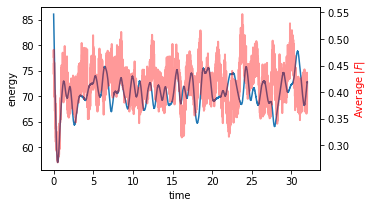

Perimeters:tensor([6.8663, 6.1008, 6.0299, 6.6097, 7.5413, 5.9961, 6.4273, 7.1168, 6.5117,
        5.7367, 5.8471, 6.4575, 6.0501, 6.3455, 6.0961, 6.3549, 6.4581, 6.0671,
        6.3709, 6.4385, 6.5092, 6.1852, 7.5384, 6.0291, 7.4882, 5.6336, 6.4125,
        6.5360, 6.6626, 5.6822, 5.8487, 6.0422, 5.8016, 5.7239, 6.5403, 6.6598,
        6.6439, 6.2205, 6.3414, 6.0465, 6.0748, 6.4224, 6.0069, 5.6978, 7.0119,
        7.3969, 5.8833, 5.9821, 6.6716, 6.4716, 6.3843, 5.5209, 6.3838, 6.8123,
        5.6640, 5.8888, 6.8424, 6.3600, 7.0473, 6.7301, 6.2461, 6.4244, 7.0048,
        6.1780, 6.7013, 6.2288, 6.1987, 6.0053, 6.0601, 8.8182, 5.9302, 6.1027,
        6.0154, 6.1153, 6.3101, 6.5215, 6.6203, 6.7759, 6.3309, 6.2531, 6.1581,
        6.1609, 7.0400, 6.5019, 6.4508, 7.1797, 5.9520, 6.3797, 5.8945, 6.1872,
        5.6905, 6.3519, 6.4465, 6.1924, 7.4804, 6.8322, 5.9423, 6.5133, 6.1664,
        5.9717], device='cuda:0')
Areas:tensor([2.2359, 2.2594, 2.1942, 2.1808, 2.2591, 2.0925, 2.1982, 2.140

In [ ]:
# Numerical integration
print('Integration (Euler\'s method):')

for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    t.append(t[-1]+Dt) # update last frame time
    # total potential energy of the system:
    E,Contractions = monolayer_energy(cell_graph,t[-1]) 
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    
    verts_t.append(cell_graph.vertices.x.detach().cpu().clone())
    verts_frames.append(t[-1])
    line_tensions.append(Contractions.detach().cpu().clone())
    
    if round((n+1)%(t_total/8))==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
Energies.append( monolayer_energy( cell_graph,t[-1])[0].item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=2)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import PIL

/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


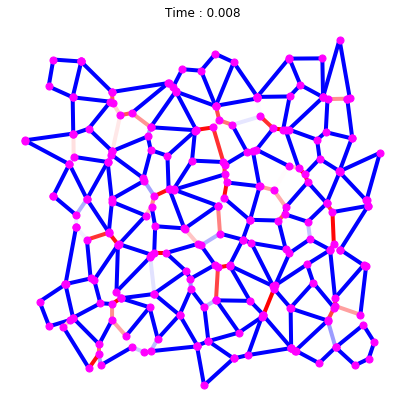

In [ ]:
fig = plt.figure(figsize=[7,7])
fig.clf()
ax = fig.subplots()
ax.axis(False);
draw_w_tension(0)
plt.show()
plt.close()

anim = animation.FuncAnimation(fig, draw_w_tension, interval=200,
                               frames = range(0,len(verts_t),max(1,round(len(verts_t)/64))))

/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


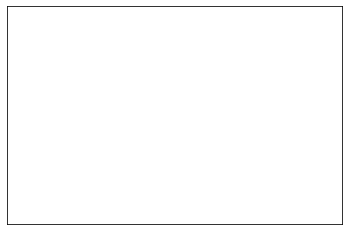

In [ ]:
HTML(anim.to_jshtml()) 

**Save as GIF**

In [ ]:
# len(verts_t)
pil_images=[]
for i in range(0,len(verts_t),5):
    fig = plt.figure(figsize=[7,7])
    fig.clf()
    ax = fig.subplots()
    ax.axis(False);
    draw_w_tension(i)
#     plt.show()
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_images.append(PIL.Image.frombytes('RGB', canvas.get_width_height(),
                                           canvas.tostring_rgb()) )
    plt.close()


In [ ]:
pil_images[0].save('sim_anisotropic_contraction.gif', format='GIF',
                   append_images=pil_images[1:], save_all=True, duration=100, loop=0)